In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [12]:
model_name_or_path = "openai/whisper-medium"
task = "transcribe"
dataset_name = "google/fleurs"
language = "Vietnamese"
language_abbr = "vi_vn"

## Comparision Wer on FlEURS __ Medium __ Lora __ Quantized Lora

In [13]:
from datasets import load_dataset, DatasetDict

fleurs = DatasetDict()

fleurs["test"] = load_dataset(dataset_name, language_abbr, split="test")

print(fleurs)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 857
    })
})


In [15]:
from datasets import Audio

fleurs = fleurs.cast_column("audio", Audio(sampling_rate=16000))

In [16]:
fleurs = fleurs.remove_columns(["id", "num_samples", "path", "raw_transcription","gender", "lang_id", "language","lang_group_id"])

In [17]:
fleurs

DatasetDict({
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 857
    })
})

### Whisper Medium OpenAi


In [42]:


import datasets
from datasets import DatasetDict, load_dataset, concatenate_datasets
from tqdm import tqdm
from transformers import (
    AutoConfig,
    AutoFeatureExtractor,
    AutoModelForSpeechSeq2Seq,
    AutoTokenizer,
    set_seed,
)
from tqdm import tqdm



from datasets import Dataset, DatasetDict
import torchaudio
from torchaudio import transforms as at
import pandas as pd
import torch
from pathlib import Path

set_seed(42)


config = AutoConfig.from_pretrained(
        "openai/whisper-medium", revision="main", use_auth_token=True
    )

config.update({"forced_decoder_ids": None, "suppress_tokens": None})



feature_extractor = AutoFeatureExtractor.from_pretrained(
        "openai/whisper-medium",
        revision="main",
        use_auth_token=True,
    )
tokenizer = AutoTokenizer.from_pretrained(
        "openai/whisper-medium",
        use_fast=True,
        revision="main",
        use_auth_token=True,
    )

tokenizer.set_prefix_tokens(language="vi", task="transcribe")

audio_column_name = "audio"
text_column_name = "transcription"
model_input_name = feature_extractor.model_input_names[0]


forward_attention_mask = True



def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids 
    batch["labels"] = tokenizer(batch[text_column_name]).input_ids
    return batch




evaluation_dataset = fleurs.map(
        prepare_dataset,
        remove_columns=["audio", "transcription"],
        num_proc=1,
        desc="preprocess train dataset",
)


/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/models/auto/configuration_auto.py:992: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/models/auto/feature_extraction_auto.py:322: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:628: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [43]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-medium", language="vi", task="transcribe")
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

         # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [44]:
from transformers import WhisperForConditionalGeneration


model = WhisperForConditionalGeneration.from_pretrained(
    model_name_or_path, device_map="auto"
)

In [27]:
evaluation_dataset

DatasetDict({
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 857
    })
})

In [34]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import gc
import evaluate
metric = evaluate.load("wer")
eval_dataloader = DataLoader(evaluation_dataset['test'], batch_size=8, collate_fn=data_collator)

model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    decoder_input_ids=batch["labels"][:, :4].to("cuda"),
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            metric.add_batch(
                predictions=decoded_preds,
                references=decoded_labels,
            )
    del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute()
print(f"{wer=}")

100%|██████████| 108/108 [09:19<00:00,  5.18s/it]

wer=24.938214396045723


In [46]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(evaluation_dataset['test'], batch_size=16, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task='transcribe')
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []
import evaluate
metric = evaluate.load("wer")
model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute(predictions=predictions, references=references)
normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/wer": wer, "eval/normalized_wer": normalized_wer}

print(f"{wer=} and {normalized_wer=}")
print(eval_metrics)

100%|██████████| 54/54 [07:20<00:00,  8.15s/it]

wer=24.934352795798578 and normalized_wer=13.639508070714834
{'eval/wer': 24.934352795798578, 'eval/normalized_wer': 13.639508070714834}


## Lora


In [47]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

         # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [48]:
import torch
from transformers import (
    AutomaticSpeechRecognitionPipeline,
    WhisperForConditionalGeneration,
    WhisperTokenizer,
    WhisperProcessor,
)
from peft import PeftModel, PeftConfig

peft_model_id = "DuyTa/vi-whisper-medium-Lora"

language = "Vietnamese"
task = "transcribe"

peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path,
)
model = PeftModel.from_pretrained(model, peft_model_id)
model.to("cuda").half()

processor = WhisperProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)



In [49]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [41]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import gc
import evaluate
metric = evaluate.load("wer")
eval_dataloader = DataLoader(evaluation_dataset['test'], batch_size=8, collate_fn=data_collator)

model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    decoder_input_ids=batch["labels"][:, :4].to("cuda"),
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            metric.add_batch(
                predictions=decoded_preds,
                references=decoded_labels,
            )
    del generated_tokens, labels, batch
    gc.collect()
wer_lora = 100 * metric.compute()
print(f"{wer_lora=}")

100%|██████████| 108/108 [12:31<00:00,  6.96s/it]

wer_lora=24.934352795798578


In [50]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(evaluation_dataset['test'], batch_size=16, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task='transcribe')
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []
import evaluate
metric = evaluate.load("wer")
model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute(predictions=predictions, references=references)
normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/wer": wer, "eval/normalized_wer": normalized_wer}

print(f"{wer=} and {normalized_wer=}")
print(eval_metrics)

100%|██████████| 54/54 [09:20<00:00, 10.39s/it]

wer=24.934352795798578 and normalized_wer=13.624135280553421
{'eval/wer': 24.934352795798578, 'eval/normalized_wer': 13.624135280553421}


## Quantization Whisper Lora

In [8]:
from whisper_quant import WhisperModel

model_size = "medium"

# Run on GPU with FP16
model = WhisperModel(model_size, device="cuda", compute_type="float16")

# or run on GPU with INT8
# model = WhisperModel(model_size, device="cuda", compute_type="int8_float16")
# or run on CPU with INT8
# model = WhisperModel(model_size, device="cpu", compute_type="int8")



In [13]:
segments, info = model.transcribe("audio.wav", beam_size=1, language ='vi',  temperature= 0)


In [14]:
for segment in segments:
    print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))

[0.00s -> 7.10s]  Hai, đây tức là một kẻ ăn mày vậy, anh ta chưa kịp quay đi thì đã thấy mấy con chó vàng chạy sồng sộc ra cứ nhảy sổ vào chân anh.


In [56]:
normalizer = BasicTextNormalizer()
norm = normalizer(segment.text)

In [57]:
norm

' hai đây tức là một kẻ ăn mầy vậy anh ta chưa kịp quay đi thì đã thấy mấy con chó vàng chạy sồng sộc ra cứ nhảy sổ vào chân anh '

In [119]:
import torch
from dataclasses import dataclass

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features):
        audios = []
        for feature in features:
            audios.append(feature["audio"])
        batch = {
            "audio": [feature["audio"]['array'] for feature in features],
            "transcription": [feature["transcription"] for feature in features]
        }
        return batch
data_collator =  DataCollatorSpeechSeq2SeqWithPadding(processor='No')

In [120]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import gc
import evaluate
metric = evaluate.load("wer")
eval_dataloader = DataLoader(fleurs['test'], batch_size=16, collate_fn=data_collator)



In [ ]:
import re
for data in eval_dataloader:
    audios = data['audio']
    transcriptions = data['transcription']
    final = []
    for audio in data['audio']:
        print("-" * 20)
        segments, info = model.transcribe(audio, beam_size=1, language='vi')
        out = [out.text for out in segments]
        pred = ''.join(out)
        norm_pred = normalizer(pred)
        final.append(norm_pred)
cleaned_text_list = [re.sub(r'\s+', ' ', text.strip()) for text in final]
    

    print(cleaned_text_list)
    print(transcriptions)
    break


In [ ]:
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():

            labels = batch["transcription"]
            print(labels)

In [ ]:
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            final = []
            labels = batch["transcription"]
            for audio in batch["audio"]:
                
                segments, _ = model.transcribe(audio, beam_size=1, language='vi')
                out = [out.text for out in segments]
                pred = ''.join(out)
                norm_pred = normalizer(pred)
                final.append(norm_pred)
            cleaned_text_list = [re.sub(r'\s+', ' ', text.strip()) for text in final]
            print(cleaned_text_list)
            print(labels)
            metric.add_batch(
                predictions=cleaned_text_list,
                references=labels,
            )
    del  labels, batch, final
    gc.collect()
wer_lora = 100 * metric.compute()
print(f"{wer_lora=}")

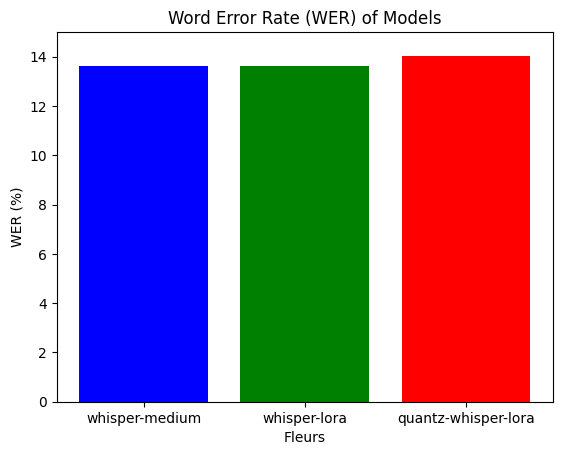

In [39]:
import matplotlib.pyplot as plt


model_names = ["whisper-medium", "whisper-lora","quantz-whisper-lora"]
wer_values = [13.639508070714834,13.624135280553421,14.044640098856966]
wer_values = [round(value, 2) for value in wer_values]

bar_colors = ['blue', 'green',"red"]
# Create a bar chart
plt.bar(model_names, wer_values,color=bar_colors)
plt.xlabel("Fleurs")
plt.ylabel("WER (%)")
plt.title("Word Error Rate (WER) of Models")
plt.ylim(0, 15)  # Set y-axis range to 0-100
plt.show()

## Vin100h

## medium

In [2]:
    # Load Dataset
from datasets import load_dataset, DatasetDict, load_from_disk
processed_dataset = DatasetDict()
processed_dataset = load_from_disk("./vin_clean")


print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['input_features', 'input_length', 'attention_mask', 'labels'],
        num_rows: 44927
    })
    test: Dataset({
        features: ['input_features', 'input_length', 'attention_mask', 'labels'],
        num_rows: 11245
    })
})


In [3]:


import datasets
from datasets import DatasetDict, load_dataset, concatenate_datasets
from tqdm import tqdm
from transformers import (
    AutoConfig,
    AutoFeatureExtractor,
    AutoModelForSpeechSeq2Seq,
    AutoTokenizer,
    set_seed,
)
from tqdm import tqdm



from datasets import Dataset, DatasetDict
import torchaudio
from torchaudio import transforms as at
import pandas as pd
import torch
from pathlib import Path

set_seed(42)


config = AutoConfig.from_pretrained(
        "openai/whisper-medium", revision="main", use_auth_token=True
    )

config.update({"forced_decoder_ids": None, "suppress_tokens": None})



feature_extractor = AutoFeatureExtractor.from_pretrained(
        "openai/whisper-medium",
        revision="main",
        use_auth_token=True,
    )
tokenizer = AutoTokenizer.from_pretrained(
        "openai/whisper-medium",
        use_fast=True,
        revision="main",
        use_auth_token=True,
    )

tokenizer.set_prefix_tokens(language="vi", task="transcribe")

audio_column_name = "audio"
text_column_name = "transcription"
model_input_name = feature_extractor.model_input_names[0]


forward_attention_mask = True



def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids 
    batch["labels"] = tokenizer(batch[text_column_name]).input_ids
    return batch


clean_data = processed_dataset['test']





/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/models/auto/configuration_auto.py:992: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/models/auto/feature_extraction_auto.py:322: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:628: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [4]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-medium", language="vi", task="transcribe")
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

         # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [39]:
clean_data

Dataset({
    features: ['input_features', 'input_length', 'attention_mask', 'labels'],
    num_rows: 11245
})

In [48]:
torch.cuda.empty_cache()

In [5]:
from transformers import WhisperForConditionalGeneration


model = WhisperForConditionalGeneration.from_pretrained(
    'openai/whisper-medium', device_map="auto"
)

In [6]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(clean_data, batch_size=16, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language="vi", task='transcribe')
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []
import evaluate
metric = evaluate.load("wer")
model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute(predictions=predictions, references=references)
normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/wer": wer, "eval/normalized_wer": normalized_wer}

print(f"{wer=} and {normalized_wer=}")
print(eval_metrics)

100%|██████████| 703/703 [1:42:04<00:00,  8.71s/it]


wer=35.96574964967958 and normalized_wer=22.798881834138733
{'eval/wer': 35.96574964967958, 'eval/normalized_wer': 22.798881834138733}


## Lora

In [7]:
import torch
from transformers import (
    AutomaticSpeechRecognitionPipeline,
    WhisperForConditionalGeneration,
    WhisperTokenizer,
    WhisperProcessor,
)
from peft import PeftModel, PeftConfig


peft_model_id = "DuyTa/vi-whisper-medium-Lora"
language = "Vietnamese"
task = "transcribe"

peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path
)
model = PeftModel.from_pretrained(model, peft_model_id)
model.to("cuda:0").half()

processor = WhisperProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)

In [8]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [9]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(clean_data, batch_size=16, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task='transcribe')
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []
import evaluate
metric = evaluate.load("wer")
model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
lora_wer = 100 * metric.compute(predictions=predictions, references=references)
lora_normalized_wer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/wer": lora_wer, "eval/normalized_wer": lora_normalized_wer}

print(f"{wer=} and {normalized_wer=}")
print(eval_metrics)

100%|██████████| 703/703 [2:13:50<00:00, 11.42s/it]  


wer=35.96574964967958 and normalized_wer=22.798881834138733
{'eval/wer': 35.95314171676819, 'eval/normalized_wer': 22.793825528564515}


### Quantized model

In [15]:
from whisper_quant import WhisperModel

model_size = "medium"

# Run on GPU with FP16
model = WhisperModel(model_size, device="cuda", compute_type="float16")

### format dataset for quantized model

In [ ]:
import logging
import numpy as np
import datasets
from datasets import DatasetDict, load_dataset, concatenate_datasets
from tqdm import tqdm
from transformers import (
    AutoConfig,
    AutoFeatureExtractor,
    AutoModelForSpeechSeq2Seq,
    AutoTokenizer,
    set_seed,
)
from transformers.utils.versions import require_version
from transformers.utils import check_min_version
from tqdm import tqdm




logger = logging.getLogger(__name__)
from datasets import Dataset, DatasetDict
import torchaudio
from torchaudio import transforms as at
import pandas as pd
import torch
from pathlib import Path

def main():
    set_seed(42)


    max_input_length = 30.0 * 16000
    min_input_length = 0.0 * 16000
    audio_column_name = "audio"
    text_column_name = "text"





    def load_wave(wave_path, sample_rate:int=16000) -> np.ndarray:
        waveform, sr = torchaudio.load(wave_path, normalize=True)
        if sample_rate != sr:
            waveform = at.Resample(sr, sample_rate)(waveform)
        return np.asarray(waveform)
    

    def get_list_files_vin100h(phase, sample_rate=16000, audio_max_sample_length=480000):
        audio_list = []
        text_list = []
        path_list = []
        if phase == 'train':
            csv_file = 'vin_train.csv'
        else:
            csv_file = 'vin_test.csv'
        df = pd.read_csv(csv_file)
        for index, row in tqdm(df.iterrows()):
            path = row['path']
            new_path = Path(row['path'])
            audio_id = index
            text = row['sentence']
            if new_path.exists():
                audio = load_wave(new_path, sample_rate=sample_rate)[0]
                if len(audio) > audio_max_sample_length or len(audio) < 0:
                    print('skip file:', new_path,'with len audio', len(audio))
                    del new_path
                    continue
            text_list.append(text)
            path_list.append(path)  

        return path_list, text_list




    # Get the testing dataset
    test_audio, test_text = get_list_files_vin100h(phase='test')
    #print(test_audio[0])
    test_dataset = Dataset.from_dict({"audio": test_audio, "text": test_text})
    vin_100h = DatasetDict({"test": test_dataset})
    #print(clean_data)


    return vin_100h, test_dataset


if __name__ == "__main__":
   clean_data, test_dataset = main()

In [20]:
clean_data

DatasetDict({
    test: Dataset({
        features: ['audio', 'text'],
        num_rows: 11245
    })
})

In [21]:

segments, _ = model.transcribe(clean_data['test']['audio'][0], beam_size=1, language='vi', temperature= 0)


In [22]:
for segment in segments :
    print(segment.text)

 Cây cam canh là loại cây ăn quả dễ chồng, dễ chăm sót và cho năng suốt cao nên hiện nay được chồng ở nhiều địa phương trong nước ta.
 Cam canh có đặc điểm phỏ mỏng, ăn rất ngọt.


In [25]:
import torch
from dataclasses import dataclass

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:

    def __call__(self, features):
        batch = {
            "audio": [feature["audio"] for feature in features],
            "transcription": [feature["text"] for feature in features]
        }
        return batch
data_collator =  DataCollatorSpeechSeq2SeqWithPadding()

In [26]:
from torch.utils.data import DataLoader
import re
from tqdm import tqdm
import numpy as np
import gc
import evaluate
metric = evaluate.load("wer")
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
normalizer = BasicTextNormalizer()
eval_dataloader = DataLoader(clean_data['test'], batch_size=16, collate_fn=data_collator)
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            final = []
            labels = batch["transcription"]
            for audio in batch["audio"]:
                
                segments, _ = model.transcribe(audio, beam_size=1, language='vi',temperature=0)
                out = [out.text for out in segments]
                pred = ''.join(out)
                norm_pred = normalizer(pred)
                final.append(norm_pred)
            cleaned_text_list = [re.sub(r'\s+', ' ', text.strip()) for text in final]
            #print(cleaned_text_list)
            #print(labels)
            metric.add_batch(
                predictions=cleaned_text_list,
                references=labels,
            )
    del  labels, batch, final
    gc.collect()
wer_quantz = 100 * metric.compute()
print(f"{wer_quantz=}")



100%|██████████| 703/703 [1:48:04<00:00,  9.22s/it]


wer_quantz=21.69356959398854


In [35]:
normalized_wer=22.798881834138733
lora_wer = 22.793825528564515

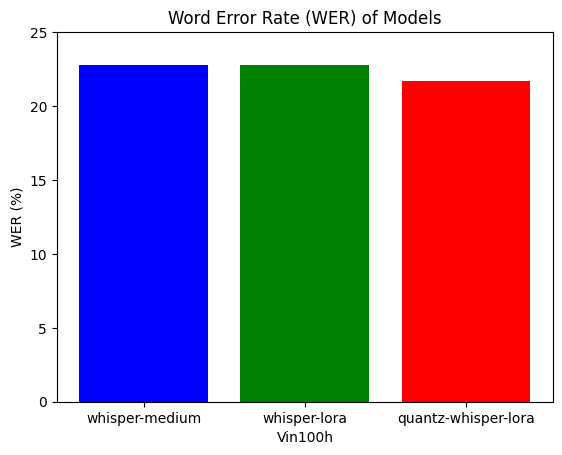

In [38]:
import matplotlib.pyplot as plt


model_names = ["whisper-medium", "whisper-lora","quantz-whisper-lora"]
wer_values = [normalized_wer,lora_wer,wer_quantz]


bar_colors = ['blue', 'green',"red"]
# Create a bar chart
plt.bar(model_names, wer_values,color=bar_colors)
plt.xlabel("Vin100h")
plt.ylabel("WER (%)")
plt.title("Word Error Rate (WER) of Models")
plt.ylim(0, 25)  # Set y-axis range to 0-100
plt.show()

In [2]:
import torch
from transformers import (
    AutomaticSpeechRecognitionPipeline,
    WhisperForConditionalGeneration,
    WhisperTokenizer,
    WhisperProcessor,
)
from peft import PeftModel, PeftConfig


peft_model_id = "DuyTa/vi-whisper-medium-Lora"
language = "Vietnamese"
task = "transcribe"

peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path
)
peft_model = PeftModel.from_pretrained(model, peft_model_id)
peft_model.to("cuda:0").half()

processor = WhisperProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)

pipe = AutomaticSpeechRecognitionPipeline(model=peft_model, tokenizer=processor.tokenizer, feature_extractor=processor.feature_extractor, batch_size=8, torch_dtype=torch.float16, device="cuda:0")

def transcribe(audio, return_timestamps=False):
    text = pipe(audio, chunk_length_s=30, return_timestamps=return_timestamps, generate_kwargs={"language": language, "task": task},)["text"]
    return text

The model 'PeftModel' is not supported for . Supported models are ['SpeechEncoderDecoderModel', 'Speech2TextForConditionalGeneration', 'SpeechT5ForSpeechToText', 'WhisperForConditionalGeneration', 'Data2VecAudioForCTC', 'HubertForCTC', 'MCTCTForCTC', 'SEWForCTC', 'SEWDForCTC', 'UniSpeechForCTC', 'UniSpeechSatForCTC', 'Wav2Vec2ForCTC', 'Wav2Vec2ConformerForCTC', 'WavLMForCTC'].


In [1]:
import torch
from transformers import pipeline
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"

pipe = pipeline(
  "automatic-speech-recognition",
  model="openai/whisper-medium",
  chunk_length_s=30,
  device=device,
)

def transcribe_hf(audio, return_timestamps=False):
    text = pipe(audio, chunk_length_s=30, return_timestamps=return_timestamps, generate_kwargs={"language": language, "task": task},max_new_tokens =448)["text"]
    return text


In [5]:
def transcribe(audio, return_timestamps=False):
    text = pipe(audio, chunk_length_s=30, return_timestamps=return_timestamps, generate_kwargs={"language": language, "task": task}, max_new_tokens =448)["text"]
    return text

In [8]:
import os
import time


import whisper
from whisper_quant import WhisperModel

#SSopenai_whisper_model = whisper.load_model("medium", device="cuda")
faster_whisper_model = WhisperModel("medium", device="cuda", compute_type = "float16")

input_file = "audio.wav"
samples = 3


# def run_openai_whisper():
#     result = openai_whisper_model.transcribe(input_file, beam_size=1)


def run_lora_whisper():
    text = transcribe(input_file)

def run_hf_whisper():
    text = transcribe_hf(input_file)

def run_faster_whisper():
    segments, _ = faster_whisper_model.transcribe(input_file, beam_size=1, best_of=1)
    segments = list(segments)


def measure_execution_time(name, func, samples=3):
    func()

    start = time.time()
    for _ in range(samples):
        func()
    end = time.time()

    print("%s: %f seconds" % (name, (end - start) / samples))


# measure_execution_time("openai-whisper", run_openai_whisper)
measure_execution_time("faster-whisper", run_faster_whisper)
measure_execution_time("lora-whisper", run_lora_whisper)
measure_execution_time("hf-whisper", run_hf_whisper)

faster-whisper: 0.643276 seconds


/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
ffmpeg: /home/tesla/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/tesla/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/tesla/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
ffmpeg: /home/tesla/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libca

lora-whisper: 2.030503 seconds


/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
ffmpeg: /home/tesla/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/tesla/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/tesla/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/transformers/generation/utils.py:1396: UserWarning: Using the model-agnostic default `max_length` (=448) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/tesla/miniconda3/envs/DUY/lib/python3.9/site-packages/t

hf-whisper: 1.959464 seconds


# MITI quantized

In [1]:
import logging
import numpy as np
import datasets
from datasets import DatasetDict, load_dataset, concatenate_datasets
from tqdm import tqdm
from transformers import (
    AutoConfig,
    AutoFeatureExtractor,
    AutoModelForSpeechSeq2Seq,
    AutoTokenizer,
    set_seed,
)
from transformers.utils.versions import require_version
from transformers.utils import check_min_version
from tqdm import tqdm




logger = logging.getLogger(__name__)
from datasets import Dataset, DatasetDict
import torchaudio
from torchaudio import transforms as at
import pandas as pd
import torch
from pathlib import Path

def main():
    set_seed(42)


    max_input_length = 30.0 * 16000
    min_input_length = 0.0 * 16000
    audio_column_name = "audio"
    text_column_name = "text"





    def load_wave(wave_path, sample_rate:int=16000) -> np.ndarray:
        waveform, sr = torchaudio.load(wave_path, normalize=True)
        if sample_rate != sr:
            waveform = at.Resample(sr, sample_rate)(waveform)
        return np.asarray(waveform)
    

    def get_list_files_MITI(phase, sample_rate=16000, audio_max_sample_length=480000):
        text_list = []
        path_list = []
        if phase == 'train':
            csv_file = 'MITI_train.csv'
        else:
            csv_file = 'MITI_test.csv'
        df = pd.read_csv(csv_file)
        for index, row in tqdm(df.iterrows()):
            path = row['path']
            new_path = Path(row['path'])
            audio_id = index
            text = row['sentence']
            if new_path.exists():
                audio = load_wave(new_path, sample_rate=sample_rate)[0]
                if len(audio) > audio_max_sample_length or len(audio) < 0:
                    print('skip file:', new_path,'with len audio', len(audio))
                    del new_path
                    continue
            text_list.append(text)
            path_list.append(path)  

        return path_list, text_list




    # Get the testing dataset
    test_audio, test_text = get_list_files_MITI(phase='test')
    #print(test_audio[0])
    test_dataset = Dataset.from_dict({"audio": test_audio, "text": test_text})
    MITI = DatasetDict({"test": test_dataset})
    #print(clean_data)


    return MITI, test_dataset


if __name__ == "__main__":
   clean_data, test_dataset = main()

420it [00:02, 153.21it/s]


In [2]:
import torch
from dataclasses import dataclass

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:

    def __call__(self, features):
        batch = {
            "audio": [feature["audio"] for feature in features],
            "transcription": [feature["text"] for feature in features]
        }
        return batch
data_collator =  DataCollatorSpeechSeq2SeqWithPadding()

In [4]:
clean_data

DatasetDict({
    test: Dataset({
        features: ['audio', 'text'],
        num_rows: 420
    })
})

In [6]:
from whisper_quant import WhisperModel

model_size = "medium"

# Run on GPU with FP16
model = WhisperModel(model_size, device="cuda", compute_type="float16")

In [8]:
from torch.utils.data import DataLoader
import re
from tqdm import tqdm
import numpy as np
import gc
import evaluate
metric = evaluate.load("wer")
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
normalizer = BasicTextNormalizer()
eval_dataloader = DataLoader(clean_data['test'], batch_size=16, collate_fn=data_collator)
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            final = []
            labels = batch["transcription"]
            for audio in batch["audio"]:
                
                segments, _ = model.transcribe(audio, beam_size=1, language='vi',temperature=0)
                out = [out.text for out in segments]
                pred = ''.join(out)
                norm_pred = normalizer(pred)
                final.append(norm_pred)
            cleaned_text_list = [re.sub(r'\s+', ' ', text.strip()) for text in final]
            #print(cleaned_text_list)
            #print(labels)
            metric.add_batch(
                predictions=cleaned_text_list,
                references=labels,
            )
    del  labels, batch, final
    gc.collect()
wer_quantz = 100 * metric.compute()
print(f"{wer_quantz=}")



  0%|          | 0/27 [00:00<?, ?it/s]

['ký hiệu tăng hạng nặng', 'tìm kiếm ký hiệu tăng hạn nặng', 'tìm kiếm tàu lửa dưa ba', 'tìm kiếm ký ức của ban chỉ huyết quân sự huyện', 'bài tới kamzang', 'nhảy tới đảo loại ta', 'hãy tới tỏa độ 21 độ 34 phút 15 giây vị độ bắc 105 độ 25 phút 30 giây kinh độ đông', 'tọ độ 23 độ 31 phút phí độ bắc 107 độ 25 phút 30 giây kinh độ đông', 'ký hiệu tàu ngầm tên lửa loại trên 3000 5000 tấn', 'nhảy tới đảo loại ta', 'tiêm kiểm đạo lý thái tố', 'ký hiệu tàu khu trục mang tên lửa đối với hải', 'tìm kiếm tàu ngầm hà nội', 'nhảy đến đảo sinh tuân đông', 'tìm kiếm tàu ráng đạo', 'chuyển tới tỏa độ 5878']
['ký hiệu tăng hạng nặng ', 'tìm kiếm ký hiệu tăng hạng nặng ', 'tìm kiếm tàu lữ dương iii ', 'tìm kiếm ký hiệu sở chỉ huy ban chỉ huy quân sự huyện ', 'bay tới cam ranh ', 'nhảy tới đảo loại ta', 'nhảy tới tọa độ 21 độ 34 phút 15 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'tọa độ 23 độ 31 phút vĩ độ bắc 107 độ 25 phút 30 giây kinh độ đông ', 'ký hiệu tàu ngầm nguyên tử loại trên 3000 5

  7%|▋         | 2/27 [00:14<02:58,  7.15s/it]

['tọa độ 24 độ 13 phút 5 giây vĩ độ bắc 109 độ 0 phút 20 giây kinh độ đông', 'tìm kiếm tàu ngầm đà nẵng', 'ký hiệu tàu pháo loại nhỏ', 'tỏa độ 6375', 'nhảy tới tỏa độ 7676', 'ký hiệu tàu khu trục mang tên lửa đối không', 'ký hiệu tàu tên lửa loại nhỏ', 'ký hiệu tàu ngầm d d loại nhỏ', 'chuyển đến tòa độ 6254', 'tìm kiếm gặt mà', 'ký hậu tàu ngầm địa diện loại lớn', 'chuyển đến cuối đường', 'nhảy tới tỏa độ 5533', 'tìm kiếm ký hiệu xe chiến đấu bộ binh', 'nhảy tới gián khoan hải dương 981', 'chuyển tới tỏa độ 56781']
['tọa độ 24 độ 13 phút 5 giây vĩ độ bắc 109 độ 0 phút 20 giây kinh độ đông ', 'tìm kiếm tàu ngầm đà nẵng ', 'ký hiệu tàu pháo loại nhỏ ', 'tọa độ 6375 ', 'nhảy tới tọa độ 7676 ', 'ký hiệu tàu khu trục mang tên lửa đối không ', 'Not found.', 'ký hiệu tàu ngầm đi e den loại nhỏ ', 'chuyển đến tọa độ 6254 ', 'tìm kiếm gạc ma', 'ký hiệu tàu ngầm đi e den loại lớn ', 'chuyển đến quế đường ', 'nhảy tới tọa độ 5533 ', 'tìm kiếm ký hiệu xe chiến đấu bộ binh ', 'nhảy tới giàn khoan 

 11%|█         | 3/27 [00:21<02:48,  7.01s/it]

['ký hiệu tàu pháo loại nhỏ', 'ký hiệu tàu tên lửa loại nhỏ', '21 độ 30 phút 10 giây ví độ bắc 1 linh tư độ 21 phút 30 giây kinh độ đông', 'nhảy tới đảo xong từ tây', 'kỷ hiệu tàu đánh cá vụ trang', 'tìm kiếm đã lên đao', 'tìm kiếm ký hiệu tàu khu trục', 'ngày đến tàu ngầm đa nắng', 'tìm kiếm quân đàn một', 'chuyển tới tòa độ 65227', 'chuyển đến tọa độ 22 độ 33 phút 15 giây vị độ bắc 105 độ 27 phút kinh độ đông', 'chuyển đến quê đường', 'chuyển đến con đảo', 'tìm kiếm ký hiệu sở chỉ huy cấp quân đoàn', 'chuyển tới toạn độ 56781', 'tìm kiếm đá suy bi']
['ký hiệu tàu pháo loại nhỏ ', 'ký hiệu tàu tên lửa loại nhỏ ', 'tọa độ 21 độ 30 phút 10 giây vĩ độ bắc 104 độ 21 phút 30 giây kinh độ đông ', 'nhảy tới đảo song tử tây ', 'ký hiệu tàu đánh cá vũ trang ', 'tìm kiếm đá len đao ', 'tìm kiếm ký hiệu tàu khu trục ', 'nhảy đến tàu ngầm đà nẵng ', 'tìm kiếm quân đoàn 1 ', 'chuyển tới tọa độ 65227 ', 'chuyển đến tọa độ 22 độ 33 phút 15 giây vĩ độ bắc 105 độ 27 phút kinh độ đông ', 'chuyển đến qu

 19%|█▊        | 5/27 [00:34<02:30,  6.83s/it]

['tìm kiếm rắn khoăn hưng vượng', 'tìm kiếm cửa phú hại', 'tạ độ 7 7 6 6', 'ký hiệu tàu ngầm nguyên tử loại 1000 3000 tấn', 'tìm kiếm ký hiệu đầu khu trục', 'ký hiệu tàu hộ vệ mang tên lửa đối không', 'nhảy tới tỏa độ 7676', 'nhảy đến tọa độ 6254', 'tìm kiếm ký hậu sở chỉ huy ban chỉ huy quân sự tính', 'ký hiệu tàu kiểm ngư', 'chuyển đến bãi phục nguyên', 'tìm kiếm tàu trường sa 630', 'tọa độ 24 độ 30 phút 11 giây phỉ độ bắc 102 độ 20 phút 30 giây kinh độ đông', 'tìm kiếm gạc ma', 'nhảy đến tọa độ 57662', 'chỉ hợp tàu sân bay chống ngầm']
['tìm kiếm giàn khoan hưng vượng ', 'tìm kiếm cửa phú hải ', 'tọa độ 7766 ', 'ký hiệu tàu ngầm nguyên tử loại 1000 3000 tấn ', 'tìm kiếm ký hiệu tàu khu trục', 'ký hiệu tàu hộ vệ mang tên lửa đối không ', 'nhảy tới tọa độ 7676 ', 'nhảy đến tọa độ 6254 ', 'tìm kiếm ký hiệu sở chỉ huy ban chỉ huy quân sự tỉnh ', 'ký hiệu tàu kiểm ngư ', 'chuyển đến bãi phúc nguyên ', 'tìm kiếm tàu trường sa 630 ', 'tọa độ 24 độ 30 phút 11 giây vĩ độ bắc 122 độ 20 phút 3

 22%|██▏       | 6/27 [00:41<02:20,  6.70s/it]

['tỏa độ 23 độ 7 phút 15 giây phí độ bắc 105 độ 25 phút 30 giây kinh độ đông', 'tìm kiếm quân khu bảy', 'ký ổ tàu ngầm nguyên tử loại trên 3000 5000 tấn', 'tìm kiếm máy bay g10', 'nhảy tới hồ chí minh', 'tìm kiếm đã bắt đầu', 'tìm kiếm máy bay kz500', 'nhảy tới tối đủ 5 năm 3 3', 'ký hiệu tàu hộ vệ mang tên lửa đối hải', 'tòa độ 6175', 'tìm kiếm ký hiệu tàu tên lửa', 'tìm kiếm tàu ngầm hà nội', 'tòa độ 34552', 'tìm kiếm quần đạo trường giao', 'nhảy tới quận ba đình', 'tìm kiếm đá tiên nữa']
['tọa độ 23 độ 7 phút 15 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'tìm kiếm quân khu 7 ', 'ký hiệu tàu ngầm nguyên tử loại trên 3000 5000 tấn ', 'tìm kiếm máy bay j 10 ', 'nhảy tới hồ chí minh ', 'tìm kiếm đá vành khăn ', 'tìm kiếm máy bay kj 500 ', 'nhảy tới tọa độ 5533 ', 'ký hiệu tàu hộ vệ mang tên lửa đối hải ', 'tọa độ 6175 ', 'tìm kiếm ký hiệu tàu tên lửa ', 'tìm kiếm tàu ngầm hà nội ', 'tọa độ 34552 ', 'tìm kiếm quần đảo trường sa ', 'chuyến tới quận ba đình ', 'tìm kiếm đá tiên 

 26%|██▌       | 7/27 [00:47<02:13,  6.69s/it]

['tọa độ 23 độ 31 phút vĩ độ bắc 107 độ 25 phút 30 giây kinh tộ đông', 'tìm kiếm ký ộng tăng hạng nhẹ', 'nhảy đến đá châu viên', 'ký hiệu tàu chống gầm cảnh giới', 'bay tới ô tàu chữ thập', 'tòa độ 62778', 'tọa độ 6375', 'tìm kiếm ký hiệu tàu tên lửa', 'và độ 21 độ 30 phút vị độ bắc 1 linh 5 độ 25 phút 30 giây kinh độ đông', 'toa độ 7 766', 'ký ợi tổ đánh ca vũ trang', 'tìm kiếm xe tăng 390', 'chuyển đến toạn độ 7676', 'nhảy đến đảo hòn che', 'toa độ 24 độ 13 phút 5 giây phí độ bắc 109 độ 0 phút 20 giây kinh độ đông', 'nhảy đến tọa độ 21 độ 30 phút 15 giây phỉ độ bắc 103 độ 25 phút 30 giây kinh độ đông']
['tọa độ 23 độ 31 phút vĩ độ bắc 107 độ 25 phút 30 giây kinh độ đông ', 'tìm kiếm ký hiệu tăng hạng nhẹ ', 'nhảy đến đá châu viên ', 'ký hiệu tàu chống ngầm cảnh giới ', 'bay tới âu tàu chữ thập ', 'tọa độ 62778 ', 'tọa độ 6375 ', 'tìm kiếm ký hiệu tàu tên lửa ', 'tọa độ 21 độ 30 phút vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'tọa độ 7766 ', 'ký hiệu tàu đánh cá vũ trang ', 'tìm

 30%|██▉       | 8/27 [00:54<02:08,  6.77s/it]

['nhảy tửi máy bay h6k', 'chuyển đến con đảo', 'ký hộng tàu ngầm nguyên tử loại trên 3000 5000 tấn', 'tọa độ 21 độ 35 phút 18 giây ví độ bắc 105 độ 25 phút 30 giây kinh độ đông', 'bay tới âu tàu đảo chữ thập', 'chuyển đến đá hoa lâu', 'chuyển lên đá hoa lau', 'tìm kiếm máy bay kz500', 'bay đến đảo hòn thơm', 'tìm kiếm ký hiệu tăng hạn chung', 'nhảy tới đảo loại ta', 'chuyển đến đại lãnh', 'chuyển tới tọa độ 5678 1', 'nhảy tới xe tăng 843', 'nhảy tới huyện tam dương vĩnh phúc', 'nhảy đến quân khu 5']
['nhảy tới máy bay h 6k ', 'chuyển đến côn đảo ', 'ký hiệu tàu ngầm nguyên tử loại trên 3000 5000 tấn ', 'tọa độ 21 độ 35 phút 18 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'bay tới âu tàu đảo chữ thập ', 'chuyển đến đá hoa lau ', 'chuyển đến đá hoa lau ', 'tìm kiếm máy bay kj 500 ', 'bay đến đảo hòn thơm ', 'tìm kiếm ký hiệu tăng hạng trung ', 'nhảy tới đảo loại ta ', 'chuyển đến đại lãnh', 'chuyển tới tọa độ 56781 ', 'nhảy tới xe tăng 843 ', 'nhảy tới huyện tam dương vĩnh phúc 

 33%|███▎      | 9/27 [01:01<02:01,  6.74s/it]

['gó độ 26 độ 0 phút 15 giây ví độ bắc 105 độ 5 phút 30 giây kinh độ đông', 'nhảy tới tọa độ 21 độ 35 phút 18 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông', 'nhảy tới tàu quang trung', 'tìm kiếm đảo trần sa', 'tìm kiếm tiểu đoàn 3', 'ngày tới tàu lữ châu 115', 'bay tới cầu tàu con đảo', 'tìm kiếm đa tiên nữ', 'ký hiệu tàu ngầm dsn loại vừa', 'tìm kiếm đá trữ thập', 'tìm kiếm bộ chỉ huy quân sự tỉnh ba rịa vũng tàu', 'tìm kiếm ký hiệu sở chỉ huy ban trị huy quân sự huyện', 'tỏ độ 21 độ 30 phút 1 giây phi độ bắc mồ linh 8 độ 25 phút 30 giây kinh nổ đông', 'tìm kiếm quân khu 7', 'nhảy đến quân khu 5', 'tòa đụ 62778']
['tọa độ 26 độ 0 phút 15 giây vĩ độ bắc 105 độ 5 phút 30 giây kinh độ đông ', 'nhảy tới tọa độ 21 độ 35 phút 18 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'nhảy tới tàu quang trung ', 'tìm kiếm đảo trường sa ', 'tìm kiếm tiểu đoàn 3 ', 'nhảy tới tàu lữ châu 115 ', 'bay tới cầu tàu côn đảo', 'tìm kiếm đá tiên nữ ', 'ký hiệu tàu ngầm đi e den loại vừa ', 'tìm k

 41%|████      | 11/27 [01:15<01:48,  6.77s/it]

['tìm kiếm bộ chỉ huy quân sự tính bà rịa vũng tàu', 'ký hiệu tàu nguyên tử loại 3000 đến 5000 tấn', 'bay tới tòa độ 6978', 'tìm kiếm ký hiệu tên lửa có cánh đất hải cơ động tầm xa', 'tìm kiếm xe tăng 390', 'tìm kiếm đảo trường sa', 'ngày tới hồ chí minh', 'ký hiệu tàu vận tài quân sự', 'tìm kiếm một con khú chín', 'tìm kiếm đá bành khăn', 'nhảy tới hà nội', 'ký hiệu tạo đánh cá nước ngoài', 'tìm kiếm đá vành khăn', 'ký hiệu sở chỉ huy cấp tiểu đoàn', 'ký hợp tàu khu trục ký hợp chung', 'nhà tự lu cút số 12']
['tìm kiếm bộ chỉ huy quân sự tỉnh bà rịa vũng tàu ', 'ký hiệu tàu ngầm nguyên tử loại trên 3000 5000 tấn ', 'bay tới tọa độ 6978 ', 'tìm kiếm ký hiệu tên lửa có cánh đất hải cơ động tầm xa ', 'tìm kiếm xe tăng 390 ', 'tìm kiếm đảo trường sa ', 'nhảy tới hồ chí minh', 'ký hiệu tàu vận tải quân sự ', 'tìm kiếm quân khu 9', 'tìm kiếm đá vành khăn ', 'nhảy tới hà nội ', 'ký hiệu tàu đánh cá nước ngoài ', 'tìm kiếm đá vành khăn ', 'ký hiệu sở chỉ huy cấp tiểu đoàn ', 'ký hiệu tàu khu 

 48%|████▊     | 13/27 [01:28<01:34,  6.75s/it]

['nhảy tới tòa độ 5 6 7 4 3', 'nhảy tới bông bay', 'nhảy đến đảo hòn che', 'ký hiệu tàu đánh cá nước ngoài', 'tìm kiếm ký ậu tên lửa có cánh đất hải tâm trung cố định mùa dạch', 'chuyển đến bãi phục nguyên', 'tìm kiếm đá chữ thập', 'tìm kiếm tàu hải dương 681', 'tìm kiếm quân khu bảy', '24 độ 30 phút 11 giây với độ bắc 122 độ 20 phút 30 giây kênh độ đông', 'nhảy tới tàu đinh tiên hoàng', 'tìm kiếm sơn ca', 'tìm kiếm ký hiệu tên lửa', 'tìm kiếm ký ậu tàu sân bay', 'tìm kiếm cảng biển vũng áng', 'nhảy tới núi cô']
['nhảy tới tọa độ 56743 ', 'nhảy tới bông bay ', 'nhảy đến đảo hòn tre ', 'ký hiệu tàu đánh cá nước ngoài ', 'tìm kiếm ký hiệu tên lửa có cánh đất hải tâm trung cố định 1 rãnh ', 'chuyển đến bãi phúc nguyên ', 'tìm kiếm đá chữ thập', 'tìm kiếm tàu hải dương 681 ', 'tìm kiếm quân khu 7 ', 'tọa độ 24 độ 30 phút 11 giây vĩ độ bắc 122 độ 20 phút 30 giây kinh độ đông ', 'nhảy tới tàu đinh tiên hoàng ', 'tìm kiếm sơn ca ', 'tìm kiếm ký hiệu tên lửa ', 'tìm kiếm ký hiệu tàu sân bay ',

 52%|█████▏    | 14/27 [01:35<01:29,  6.85s/it]

['tìm kiếm ký hiệu tăng hạng chung', 'tìm kiếm ký hiệu tên lửa có cánh', 'di chuyển tới đá thị', 'chuyển đến đảo bình nguyên', 'nhảy đến quân khu 5', 'tìm kiếm ký hiệu xe trên đấu bộ binh', 'chuyển đến tỏ độ 5533', 'tòa đỗ x4 756', 'tìm kiếm tàu sân bay liêu ninh', 'chuyển đến bãi đá thuyền chai', 'ký ủ tàu pháo lại nhỏ', 'ký hiệu tàu hộ vệ mang tên lửa đối hải', 'trong team kiếm hoan hải', 'tìm kiếm ký hiệu tàu tuần tiểu chính xác', 'đìm kiếm cửa phú hại', 'tỏa độ 6175']
['tìm kiếm ký hiệu tăng hạng trung ', 'tìm kiếm ký hiệu tên lửa có cánh', 'di chuyển tới đá thị ', 'chuyển đến đảo bình nguyên ', 'nhảy đến quân khu 5 ', 'tìm kiếm ký hiệu xe chiến đấu bộ binh ', 'chuyển đến tọa độ 5533 ', 'tọa độ 64756 ', 'tìm kiếm tàu sân bay liêu ninh ', 'chuyển đến bãi đá thuyền chài ', 'ký hiệu tàu pháo loại nhỏ ', 'ký hiệu tàu hộ vệ mang tên lửa đối hải ', 'tìm kiếm hòn hải ', 'tìm kiếm ký hiệu tàu tuần tiễu trinh sát ', 'tìm kiếm cửa phú hải ', 'tọa độ 6175 ']


 59%|█████▉    | 16/27 [01:49<01:16,  6.92s/it]

['nhảy đến đảo hoàng chia', 'chuyển đến toa độ 22 độ 33 phút 15 giây vĩ đô bắc một linh 5 độ 27 phút kinh độ đồng', 'tìm ký hiệu tàu tuần tiểu chính xác', 'tỏa độ 21 độ 30 phút 15 giây phía độ bắc 105 độ 20 phút 30 giây kinh độ đông', 'nhảy tới tàu ngọc đình 995', 'chuyển đến đại lãnh', 'chuyển đến cuối đường', 'tìm kiếm giàn khoan hưm vượng', 'tìm kiếm đá trước thập', 'chuyển đến đá hoa lâu', 'nhảy tới toa độ 7676', 'chuyên đến toa độ 76', 'tìm kiếm ký hiệu tên lửa có cánh', 'tìm kiếm ký hiệu tên lửa có cánh đất hải tâm trung cố định 2 dãnh', 'nhảy tới gián khoan hải dương 981', 'tỏa độ 21 độ 14 phút vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông']
['nhảy đến đảo hòn tre ', 'chuyển đến tọa độ 22 độ 33 phút 15 giây vĩ độ bắc 105 độ 27 phút kinh độ đông ', 'tìm tìm kiếm ký hiệu tên lửa có cánh đất hải trung tâm cố định 2 rãnh', 'tọa độ 21 độ 34 phút 15 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'nhảy tới tàu ngọc đình 995 ', 'chuyển đến đại lãnh ', 'chuyển đến quế đường ', 'tì

 63%|██████▎   | 17/27 [01:56<01:08,  6.90s/it]

['tìm kiếm cam răng', 'chuyển đến đảo bình nguyên', 'chúng ta sẽ tìm kiếm hòn hài', 'tìm kiếm ký hiệu câu vận tài', 'tìm kiếm tàu lửa dương 3', 'ký ủ tàu đánh cá vũ trang', 'tìm kiếm ký ẩu tàu ngắm chính xác vô tuyến địa tử', 'nhảy tới tàu ngọc đình 995', 'tìm kiếm tàu hải cảnh 127', 'chuyển tới tọa độ 65227', 'tìm kiếm đá núi le', '23 độ 19 phút 2 giây với độ bắc 105 độ 20 phút 3 giây kinh độ đông', 'tìm kiếm tàu trường xa 630', 'di chuyển tới cầu càng đảo ba đinh', 'tìm kiếm tàu trường xa 630', 'bay tới cam danh']
['tìm kiếm cam ranh ', 'chuyển đến đảo bình nguyên ', 'tìm kiếm hòn hải ', 'tìm kiếm ký hiệu tàu vận tải ', 'tìm kiếm tàu lữ dương iii ', 'ký hiệu tàu đánh cá vũ trang ', 'tìm kiếm ký hiệu tàu ngầm trinh sát vô tuyến điện tử ', 'nhảy tới tàu ngọc đình 995 ', 'tìm kiếm tàu hải cảnh 127 ', 'chuyển tới tọa độ 65227 ', 'tìm kiếm đá núi le', 'tọa độ 23 độ 19 phút 2 giây vĩ độ bắc 105 độ 20 phút 3 giây kinh độ đông ', 'tìm kiếm tàu trường sa 630 ', 'di chuyển tới cầu cảng đảo ba 

 67%|██████▋   | 18/27 [02:03<01:02,  6.97s/it]

['ký hợp tàu sinh bay chống ngầm', 'bay đến đảo hoàng thương', 'nhảy tưới fan răng', 'tọa độ 14 độ 30 phút 15 giây vĩ độ bắc 105 độ 0 phút 30 giây kinh độ đông', 'nhảy tới fan vinh', 'tìm kiếm ký hợp xe chiến đấu bộ bình', 'cả độ 14 độ 30 phút 15 giây ví độ bắc một linh nằm độ 0 phút 30 giây kinh độ đông', 'tìm kiếm ký hiệu tiên lửa có cánh đất hải tâm trung cố định một rãnh', 'nhảy tới phan rang', 'đi vào tàu văn tải quân sự', 'đi tìm kiếm tiểu đoàn bà', 'ký ức tàu chổ ngâm', 'tìm kiếm bộ chỉ huy quân sự tỉnh bà rịa vũng tàu', 'chuyển đến toa độ 7676', 'tìm kiếm ký hiệu tên lửa có cánh', 'tìm kiếm tàu hải dương 61']
['ký hiệu tàu sân bay chống ngầm ', 'bay đến đảo hòn thơm ', 'nhảy tới phan rang ', 'tọa độ 14 độ 30 phút 15 giây vĩ độ bắc 105 độ 0 phút 30 giây kinh độ đông ', 'nhảy tới phan vinh ', 'tìm kiếm ký hiệu xe chiến đấu bộ binh ', 'tọa độ 14 độ 30 phút 15 giây vĩ độ bắc 105 độ 0 phút 30 giây kinh độ đông ', 'tìm kiếm ký hiệu tên lửa có cánh đất hải tâm trung cố định 1 rãnh ', 

 74%|███████▍  | 20/27 [02:18<00:49,  7.12s/it]

['tạ độ 65227', 'tỏa độ 5 6 7 4 3', 'tìm kiếm ký tàu tên lửa', 'chuyển đến tọa độ 5533', '21 độ 30 phút 15 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông', 'nhảy đến tỏa độ 21 độ 30 phút 10 giây ví độ bắc 104 độ 21 phút 30 giây kinh độ đông', 'tìm kiếm ký ẩu sở chỉ huy cấp quân đoàn', 'tìm kiếm ký hiệu tàu vận tải', 'tìm kiếm đã nối lại', 'kỷ hiệu tàu đánh cá quốc doanh', 'chuyển đến tọa độ 21 độ 30 phút 1 giây phỹ độ bắc 108 độ 25 phút 30 giây kinh độ đông', 'tìm kiểm quân khu chín', 'toạ độ 21 độ 34 phút 15 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông', 'tìm kiếm đá len đao', 'kiến nhu tạo hải gắn hại', 'tỏa độ 27 độ 20 phút 5 giây vị độ bắc một linh năm độ 25 phút 30 giây kinh độ đông']
['tọa độ 65227 ', 'tọa độ 56743 ', 'tìm kiếm ký hiệu tàu tên lửa ', 'chuyển đến tọa độ 5533 ', 'chuyển đến tọa độ 5533 ', 'nhảy đến tọa độ 21 độ 30 phút 10 giây vĩ độ bắc 104 độ 21 phút 30 giây kinh độ đông ', 'tìm kiếm ký hiệu sở chỉ huy cấp quân đoàn ', 'tìm kiếm ký hiệu tàu vận tải ', 't

 78%|███████▊  | 21/27 [02:25<00:42,  7.11s/it]

['tìm kiếm tàu nghiên cứu nam phong', 'nhảy đến đảo lý sơn', 'nhảy tới bông bay', 'tìm kiếm đá núi le', 'nhảy tới lo cút 12', 'ký hiệu tàu hải cảnh', 'tại độ 21 độ 34 phút 15 giây ví độ bắc 1 ít âm độ 25 phút 30 giây kinh độ đông', 'ký hiệu tàu ngầm nguyên tử loại trên 3000 5000 tấn', 'ký ức tạm ngầm nguyên tử loại 1000 3000 tấn ức', 'ký ủng hộ hải kênh 2', 'điểm kiểm đạo lý thái độ', 'ngày tới tỏa đụ 5 6 7 8 1', 'tìm kiếm chi tôn', 'chuyển đến tọa độ 22 độ 33 phút 15 giây vít ở bắc mùa đi 5 độ 27 phút kinh độ đông', 'bay tới toả độ 76413', 'chuyển đến tỏ độ 22 độ và 3 phút 15 giây video bắc mồ linh 5 độ 27 phút kinh tố đông']
['tìm kiếm tàu nghiên cứu nam phong ', 'nhảy đến đảo lý sơn ', 'nhảy tới bông bay ', 'tìm kiếm đá núi le ', 'nhảy tới lô cốt số 12 ', 'ký hiệu tàu hải cảnh ', 'tọa độ 21 độ 34 phút 15 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'ký hiệu tàu ngầm nguyên tử loại trên 3000 5000 tấn ', 'ký hiệu tàu ngầm nguyên tử loại 1000 3000 tấn ', 'ký hiệu tàu hải cảnh 

 85%|████████▌ | 23/27 [02:39<00:28,  7.14s/it]

['tìm kiếm tàu ngầm hà nội', 'tìm kiếm ký hiệu sở chỉ vi cấp lữ đoàn', 'tìm kiếm ký hiệu to vẫn tại', 'tìm kiếm đảo hòn khoai', 'ký hiệu tên lửa có cánh đất hải cơ động tầm gần', 'tỏ độ 1 2 3 1 5', 'bay tới tận độ 76413', 'chuyển đến tỏa độ 5533', 'ký hiệu tàu ngầm dsn loại nhỏ', 'nhảy tới tàu lữ châu 115', 'tìm kiếm ký hiệu sở chỉ huy cấp quân khu', 'tìm kiếm tàu hải cạnh 127', 'tìm kiếm đá tiên nữ', 'nhảy tới toa độ 69 78', 'tìm kiếm máy bay dhc6', 'nhảy tới hà nội']
['tìm kiếm tàu ngầm hà nội ', 'tìm kiếm ký hiệu sở chỉ huy cấp lữ đoàn ', 'tìm kiếm ký hiệu tàu vận tải ', 'tìm kiếm đảo hòn khoai ', 'ký hiệu tên lửa có cánh đất hải cơ động tầm gần ', 'tọa độ 12315 ', 'bay tới tọa độ 76413 ', 'nhảy tới tọa độ 5533 ', 'ký hiệu tàu ngầm đi e den loại nhỏ ', 'nhảy tới tàu lữ châu 115 ', 'tìm kiếm ký hiệu sở chỉ huy cấp quân khu ', 'tìm kiếm tàu hải cảnh 127 ', 'tìm kiếm đá tiên nữ ', 'nhảy tới tọa độ 6978 ', 'tìm kiếm máy bay dhc 6 ', 'nhảy tới hà nội ']
['tìm kiếm lo cốt số 10', 'nhảy tớ

 93%|█████████▎| 25/27 [02:54<00:14,  7.24s/it]

['tìm kiếm ký hữu tăng hạng nhẹ', 'tìm kiếm tàu nghiên cứu nam phong', 'xoá độ 61761', 'nhạc điện thoại độ 21 độ 30 phút 10 giây phi độ bắc mồ linh 4 độ 21 phút 30 giây kinh độ đông', 'tìm kiếm đã tây', 'tọa độ 27 độ 20 phút 5 giây vì độ bắc mổ linh âm độ 25 phút 30 giây kinh tử đông', 'nhảy tới tọa độ 5 6 7 8 1', 'tìm kiếm ký hữu tàu đánh cá', 'chí hậu đau hài cạnh hài', 'tọa độ 27 độ 20 phút 5 giây vĩa độ pắc 105 độ 25 phút 30 giây kinh độ đông', 'nhảy tới tàu lữ châu 115', 'ký hiệu tàu khu trục mang tên lửa đối không', 'ký hước tàu ngầm chống tàu ngầm', 'chuyển đến tạ độ 23 độ 7 phút 15 giây ví độ bắc 105 độ 25 phút 30 giây kinh độ đông', 'nhảy đến bông bay', 'nhảy tới núi cô']
['tìm kiếm ký hiệu tăng hạng nhẹ ', 'tìm kiếm tàu nghiên cứu nam phong ', 'tọa độ 61761 ', 'nhảy đến tọa độ 21 độ 30 phút 10 giây vĩ độ bắc 104 độ 21 phút 30 giây kinh độ đông ', 'tìm kiếm đá tây ', 'tọa độ 27 độ 20 phút 5 giây vĩ độ bắc 105 độ 25 phút 30 giây kinh độ đông ', 'nhảy tới tọa độ 56781 ', 'tìm ki

100%|██████████| 27/27 [03:02<00:00,  5.47s/it]

['tọa độ 62 778', 'tìm kiếm máy bay kz500', 'tìm kiếm ký hậu tàu tên lửa', 'bay tới tỏa độ 69 78']
['tọa độ 62778 ', 'tìm kiếm máy bay kj 500 ', 'tìm kiếm ký hiệu tàu tên lửa ', 'bay tới tọa độ 6978 ']


100%|██████████| 27/27 [03:02<00:00,  6.77s/it]

wer_quantz=22.51896813353566
